# Test plane extraction for a single point cloud

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import open3d as o3d

import planeslam.mesh as mesh
import planeslam.general as general
from planeslam.scanrep import ScanRep
from planeslam.extraction import scan_from_clusters

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Read Point Cloud from pcd file

In [3]:
# Read in point cloud data
pcfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_100.pcd')
pcd = o3d.io.read_point_cloud(pcfile)
P = np.asarray(pcd.points)

In [4]:
# Convert points to ENU
P = general.NED_to_ENU(P)

Cluster the points

In [5]:
start_time = time.time()
P = general.downsample(P, factor=5, axis=0)
m = mesh.lidar_mesh(P)
# Prune the mesh for long edges
m = mesh.prune_mesh(P, m, 10)
# Cluster the mesh with graph search
clusters, avg_normals = mesh.cluster_mesh_graph_search(P, m)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.3496086597442627


Text(0.5, 0.5, 'Y')

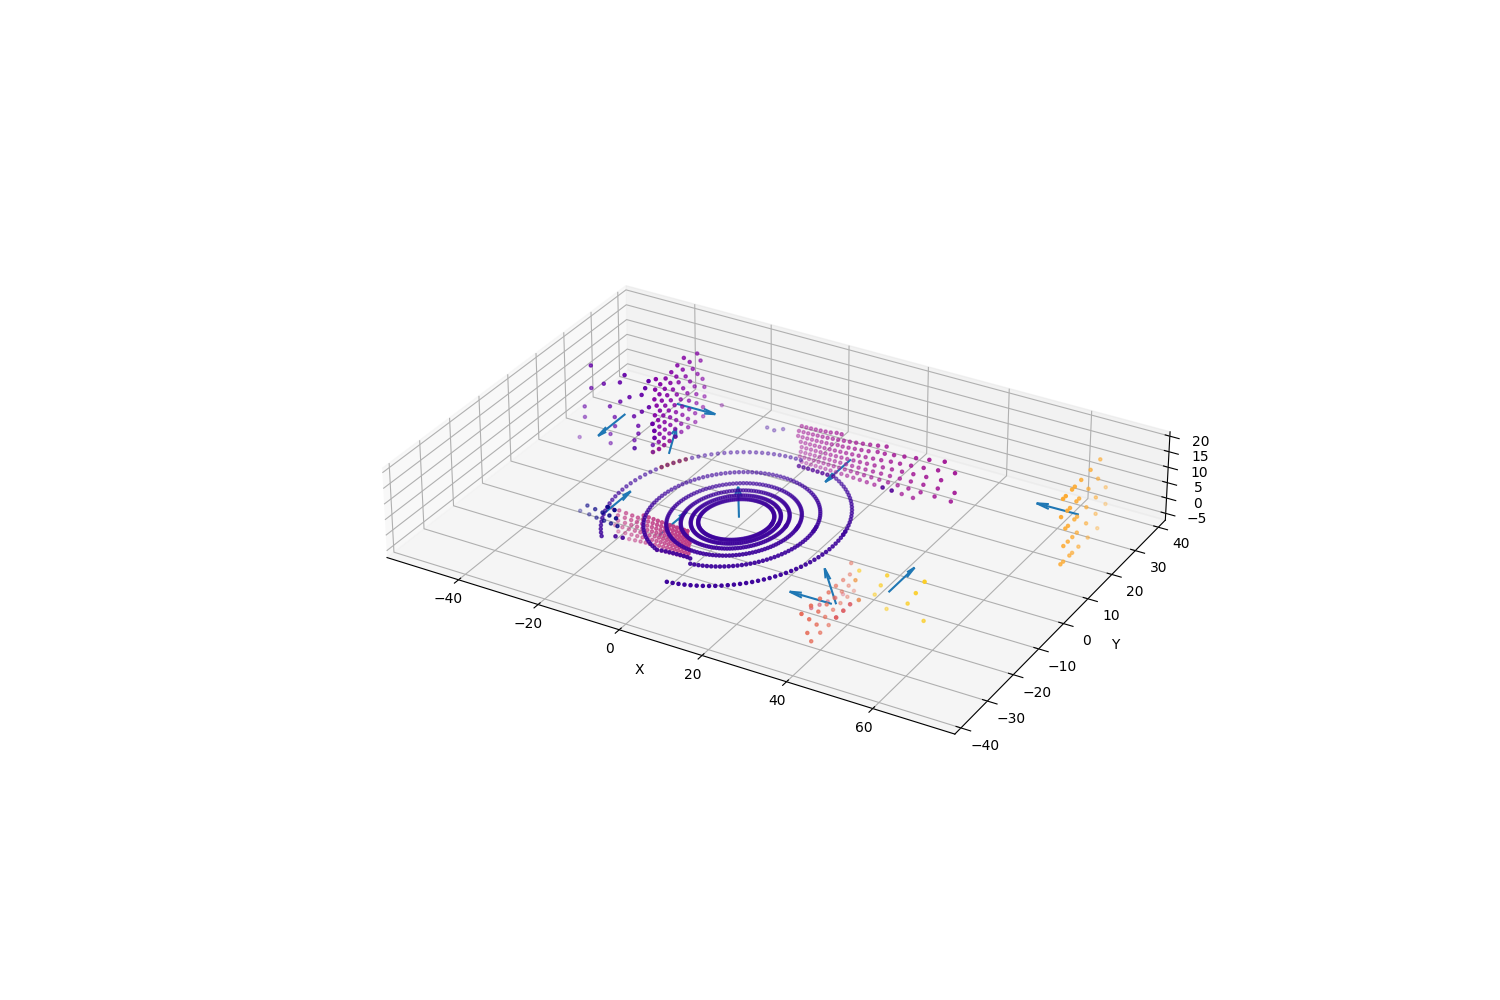

In [6]:
# Plot clusters
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, c in enumerate(clusters):
    cluster_pts_idxs = np.unique(m.simplices[c,:]) 
    cluster_pts = P[cluster_pts_idxs,:]
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color=colors[i,:], marker='.')  

    # Show normals
    c = np.mean(cluster_pts, axis=0)
    n = 10 * avg_normals[i]
    ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2])

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")


min  [-20.18542862   9.45113277]
max  [-11.05561924  14.64942169]
min  [-35.25487518 -26.04901695]
max  [23.64163971 33.95123291]
min  [-49.60928726  -5.38921022]
max  [-30.15239525  19.57162285]
min  [13.10144997 -5.01792765]
max  [37.64985657 19.48218536]
min  [ 0.01709228 -4.39075518]
max  [38.95376205 10.74595261]
min  [-19.70949554  -4.73007441]
max  [-0.30784649  5.13258886]
min  [ 32.14193344 -24.16753578]
max  [ 40.67399216 -14.20746326]
min  [-36.83708954  -1.81553841]
max  [-17.05118561  10.91353607]
min  [-30.47517204  10.41631985]
max  [-23.50814438  20.87159729]
min  [13.68096828 -2.64624381]
max  [32.4568634  18.87556076]
min  [39.924366   -2.04109049]
max  [56.00477982 10.31517887]


Text(0.5, 0.5, 'Y')

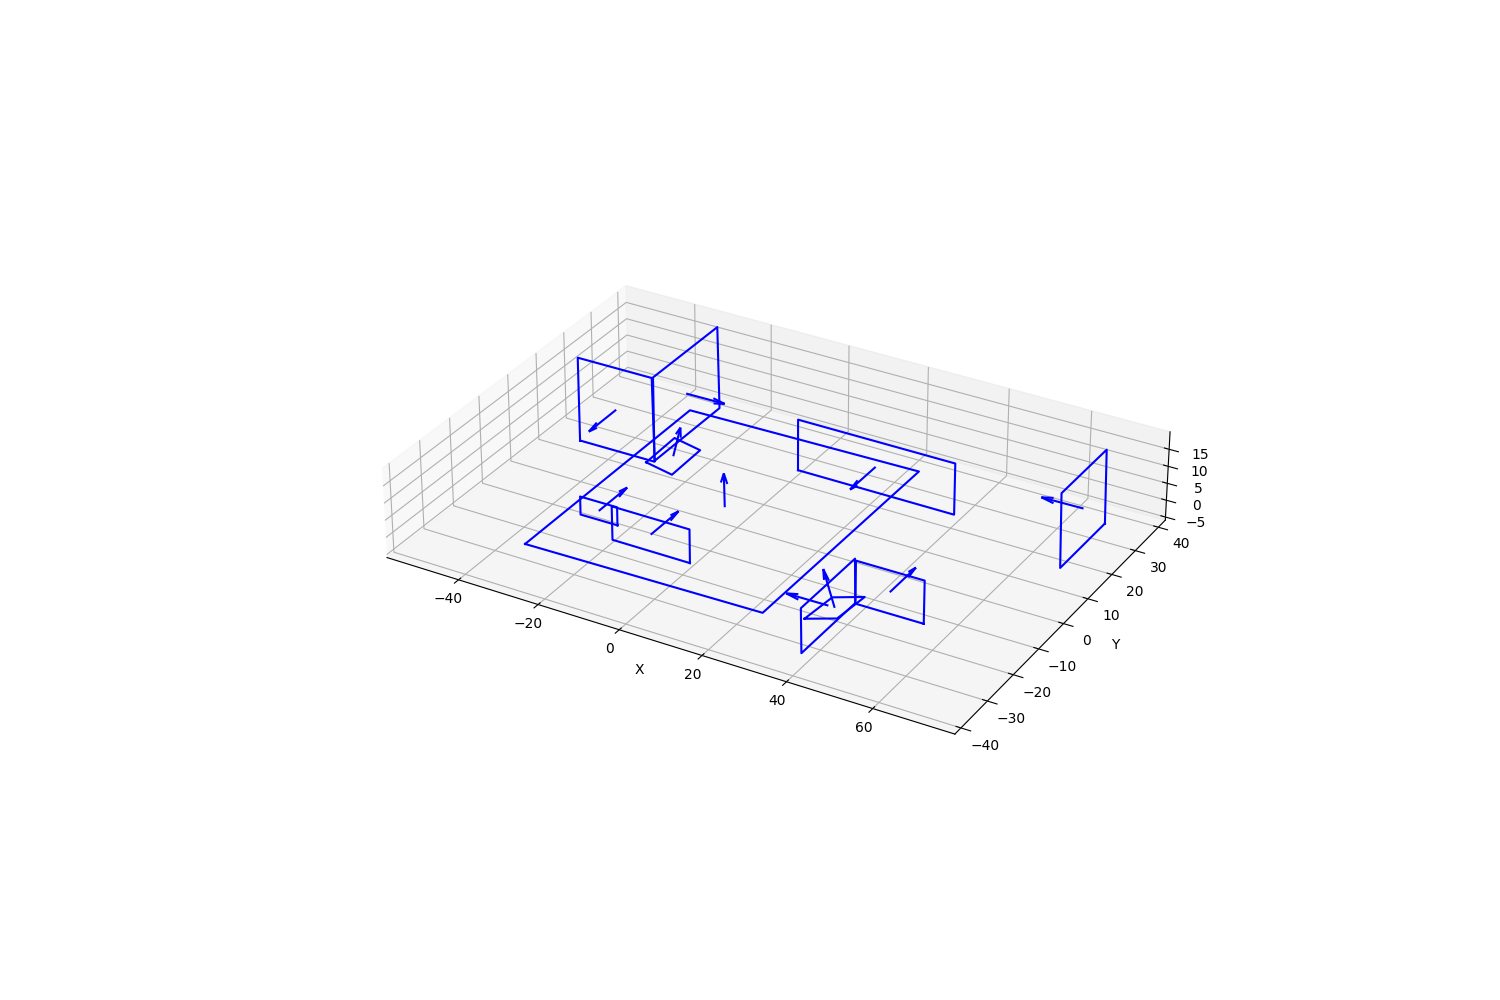

In [7]:
from planeslam.extraction import bd_plane_from_pts
from planeslam.plane import BoundedPlane

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i, c in enumerate(clusters):
    n = avg_normals[i][:,None]
    cluster_pts_idxs = np.unique(m.simplices[c,:]) 
    cluster_pts = P[cluster_pts_idxs,:]

    verts = bd_plane_from_pts(cluster_pts, n)
    bplane = BoundedPlane(verts)
    bplane.plot(ax, show_normal=True)

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [10]:
def test(*args):
    print(len(args))

test(verts)

1


Extract planes

In [6]:
vertices, faces, normals = scan_from_clusters(P, m, clusters, avg_normals)
scan = ScanRep(vertices, faces, normals)

AttributeError: module 'planeslam.mesh' has no attribute 'scan_from_clusters'

Text(0.5, 0.5, 'Y')

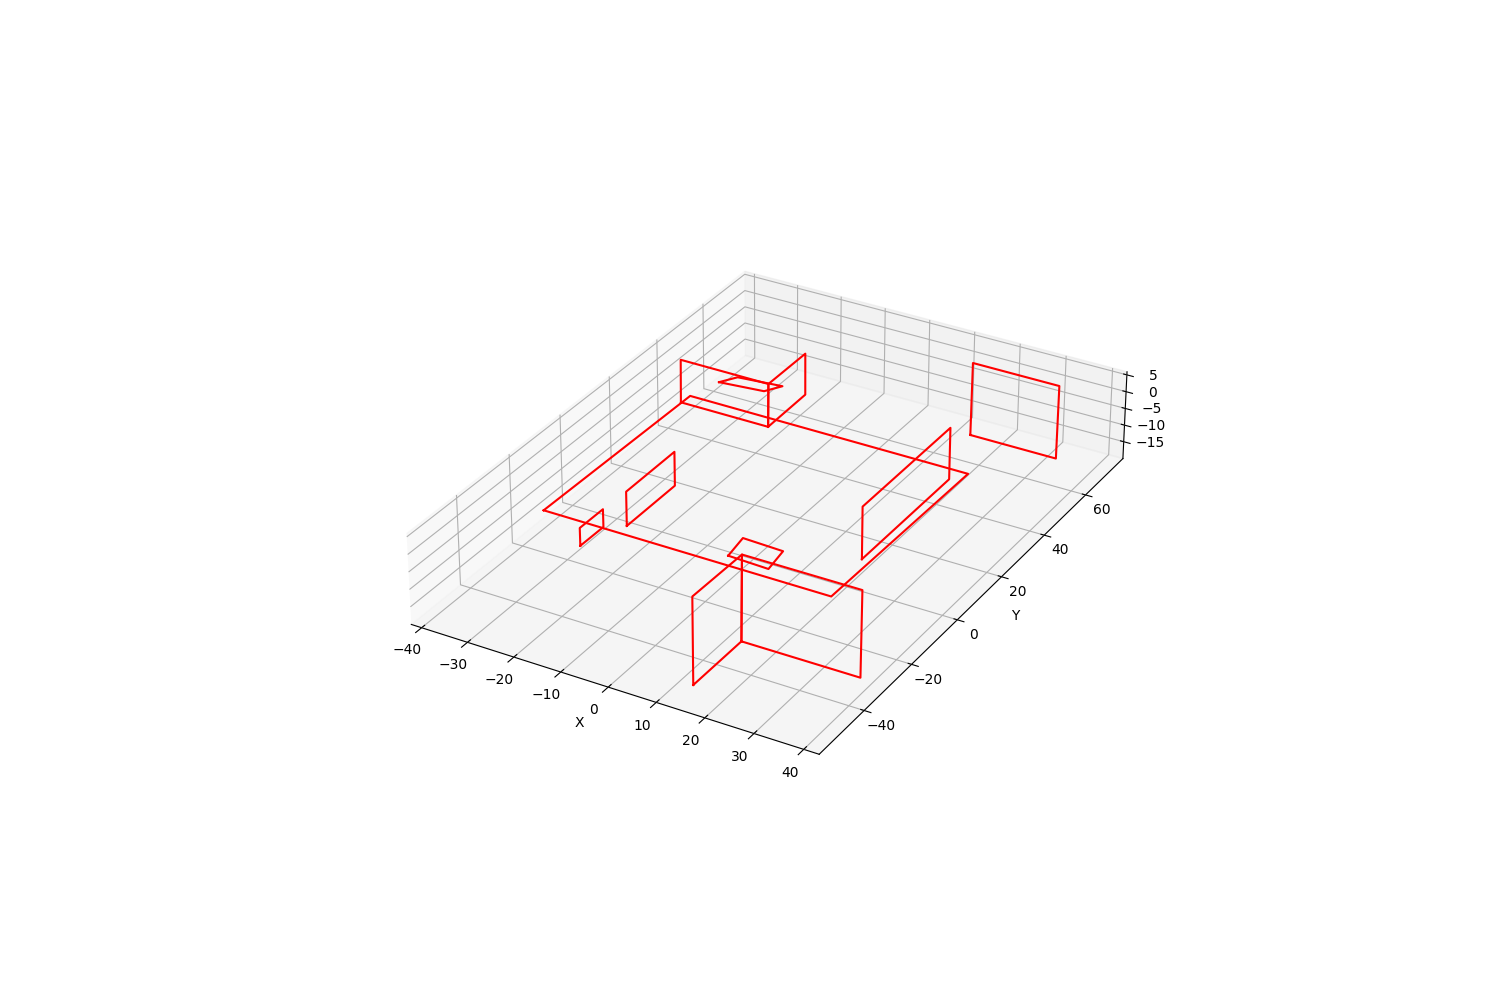

In [15]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scan.plot(ax, color='r', show_normals=True)

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")